In [5]:
import os
print(os.getcwd())
import sys
sys.path.append('/local/scratch/kchan76/sparse-coarse-operator/')
from libs.pde import *
from libs.rotated_laplacian import RotatedLaplacian
from libs.models import BasicNet, MultiHeadedAttention
import torch


device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('device:', device)

/local/scratch/kchan76/sparse-coarse-operator
device: cuda:2


# 3-Level Attention 

In [6]:
pi_num = 2
list_theta = [np.pi/pi_num]
npts = 3
# num_low = 0
# num_high = 1
# eps_low = 10**(-num_high)
# eps_high = 10**(-num_low)
# list_eps = np.logspace(-num_high, -num_low, npts)

eps_low = 0.1
eps_high = 0.2

list_eps = np.linspace(eps_low,eps_high, npts)

In [7]:
train_grid_size = 31
k2 = 2
k3 = 3
same_vecs = False
PDE = RotatedLaplacian(train_grid_size,[k2,k3],list_eps, list_theta,'fixed theta',same_vecs=same_vecs)

In [8]:
# LEVEL 2
# seed = seed+1
seed = 7
print('seed:', seed)
set_global_seed(seed)
h = 8
dhid = 256
epochs = 1500
adam_decay_rate = 0 # adam weight decay
lr = 1e-3 # learning rate
lr_decay_rate = .5 # learning rate decay
lr_decay_step = 1000 # learning rate decay step size
init = 'xavier normal' # "<name> <distribution>" name={'xavier', 'kaiming'} distribution={'uniform', 'normal'}

ncopy = 1
single_model = False # KEEP IT FALSE!! if true, only model_prob will be learned
softmax_topk = False
dropout = 0.5

model_prob_l2 = MultiHeadedAttention(h ,dhid, ncopy=ncopy, init=init, dropout=dropout)
model_value_l2 = MultiHeadedAttention(h, dhid, ncopy=ncopy, init=init, dropout=dropout)


model_prob_l2,model_value_l2 = PDE.train(PDE.A2_train, 
                                         PDE.s2_train,
                                         PDE.eig_vec2_train,
                                         model_prob_l2,
                                         model_value_l2,
                                         epochs,
                                         adam_decay_rate,
                                         lr,
                                         lr_decay_rate,
                                         lr_decay_step,
                                         device,
                                         single_model=single_model,
                                         softmax_on = softmax_topk,
                                         verbose = True)




seed: 7
 epoch:  0  loss:  tensor(0.0150, device='cuda:2', dtype=torch.float64, grad_fn=<AddBackward0>)
 epoch:  250  loss:  tensor(0.0002, device='cuda:2', dtype=torch.float64, grad_fn=<AddBackward0>)
 epoch:  500  loss:  tensor(5.4628e-05, device='cuda:2', dtype=torch.float64,
       grad_fn=<AddBackward0>)
 epoch:  750  loss:  tensor(1.9704e-05, device='cuda:2', dtype=torch.float64,
       grad_fn=<AddBackward0>)
 epoch:  1000  loss:  tensor(1.2410e-05, device='cuda:2', dtype=torch.float64,
       grad_fn=<AddBackward0>)
 epoch:  1250  loss:  tensor(7.1413e-06, device='cuda:2', dtype=torch.float64,
       grad_fn=<AddBackward0>)
 epoch:  1499  loss:  tensor(3.3659e-06, device='cuda:2', dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [159]:
# test level-2 model
test_seed = 140
# seed_list_255 = []
# for test_seed in seed_list_255:
while True:
#     test_seed = test_seed + 1
    set_global_seed(test_seed)
#     sizes = [63,127,255,511]
    sizes = [383]
    print('test seed:', test_seed)
    num_test = 10
    models = {}
    models['level2'] = model_prob_l2, model_value_l2
#     test_grid_size = 511
    max_levels = 2
    theta = tuple(list_theta)
    epsilon = (eps_low, eps_high)
    random_test = True
    accel = None
#     accel ='gmres'


    for test_grid_size in sizes:
        print('size:', test_grid_size)
        set_global_seed(test_seed)
        num_iter_standard, num_iter_learning, epsList, xs, xl = PDE.test_model(num_test,
                                                                    models,
                                                                    test_grid_size,
                                                                    max_levels,
                                                                    epsilon,
                                                                    theta,
                                                                    device,
                                                                    top_accel = accel,
                                                                    random_test=random_test,
                                                                    single_model=single_model,
                                                                    softmax_on = softmax_topk,
                                                                    verbose = True)
#     if np.mean(num_iter_learning)-np.mean(num_iter_standard) < 5:
#         seed_list_255.append(test_seed)
#         print(seed_list_255)
    break


test seed: 140
size: 383
standard stencil iter:    133.7   standard stencil time:   5.048768401145935
learned stencil iter:    158.9   learned stencil time:   5.282956337928772


In [160]:
print(num_iter_standard)
print(num_iter_learning)
# print(thetaList)

[100, 150, 166, 131, 167, 129, 154, 107, 142, 91]
[146, 112, 124, 97, 256, 161, 171, 249, 173, 100]


## Level 3

In [13]:
# LEVEL 3
l3_seed = 62
print('seed:', l3_seed)
set_global_seed(l3_seed)
h3 = 8
dhid3 = 256
epochs3 = 1500
adam_decay_rate3 = 0 # adam weight decay
lr3 = 1e-4 # learning rate
lr_decay_rate3 = 1 # learning rate decay
lr_decay_step3 = 500 # learning rate decay step size
init3 = 'xavier uniform' 

ncopy3 = 1
single_model3 = False
softmax_topk3 = True
dropout3 = 0.2

model_prob_l3 = MultiHeadedAttention(h3 ,dhid3, ncopy=ncopy3, init=init3, dropout=dropout3)
model_value_l3 = MultiHeadedAttention(h3, dhid3, ncopy=ncopy3, init=init3, dropout=dropout3)

model_prob_l3,model_value_l3 = PDE.train(PDE.A3_train, 
                                         PDE.s3_train,
                                         PDE.eig_vec3_train,
                                         model_prob_l3,
                                         model_value_l3,
                                         epochs3,
                                         adam_decay_rate3,
                                         lr3,
                                         lr_decay_rate3,
                                         lr_decay_step3,
                                         device,
                                         single_model= single_model3,
                                         softmax_on = softmax_topk3,
                                         verbose = True)

seed: 62
 epoch:  0  loss:  tensor(0.0167, device='cuda:2', dtype=torch.float64, grad_fn=<AddBackward0>)
 epoch:  250  loss:  tensor(0.0003, device='cuda:2', dtype=torch.float64, grad_fn=<AddBackward0>)
 epoch:  500  loss:  tensor(0.0002, device='cuda:2', dtype=torch.float64, grad_fn=<AddBackward0>)
 epoch:  750  loss:  tensor(0.0002, device='cuda:2', dtype=torch.float64, grad_fn=<AddBackward0>)
 epoch:  1000  loss:  tensor(0.0010, device='cuda:2', dtype=torch.float64, grad_fn=<AddBackward0>)
 epoch:  1250  loss:  tensor(4.1847e-05, device='cuda:2', dtype=torch.float64,
       grad_fn=<AddBackward0>)
 epoch:  1499  loss:  tensor(3.3970e-05, device='cuda:2', dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [14]:
Ag = []
Ac = []

In [16]:
test_seed = 142
set_global_seed(test_seed)
print('test seed:', test_seed)
num_test = 10
models = {}
models['level2'] = model_prob_l2, model_value_l2
models['level3'] = model_prob_l3, model_value_l3
# test_grid_size =63
random_test = True
sizes = [63,95,127,191,255,383,511]
# sizes = [63]
max_levels = 3
theta = tuple(list_theta)
epsilon = (eps_low, eps_high)
for test_grid_size in sizes:
    print('size:',test_grid_size)
    set_global_seed(test_seed)
    num_iter_standard, num_iter_learning, ThetaList,_, _ = PDE.test_model(num_test,
                                                                models,
                                                                test_grid_size,
                                                                max_levels,
                                                                epsilon,
                                                                theta,
                                                                device,
                                                                dropout_on = False,
                                                                random_test = random_test,
                                                                single_model=single_model,
                                                                softmax_on = softmax_topk,
                                                                verbose = True)
    Ag.append(np.mean(num_iter_standard))
    Ac.append(np.mean(num_iter_learning))

test seed: 142
size: 63
standard stencil iter:    22.2   standard stencil time:   0.027274703979492186
learned stencil iter:    22.9   learned stencil time:   0.05671591758728027
size: 95
standard stencil iter:    21.9   standard stencil time:   0.06354608535766601
learned stencil iter:    22.8   learned stencil time:   0.11449649333953857
size: 127
standard stencil iter:    22.1   standard stencil time:   0.28757970333099364
learned stencil iter:    22.8   learned stencil time:   0.3628232955932617
size: 191
standard stencil iter:    21.9   standard stencil time:   0.49368350505828856
learned stencil iter:    22.6   learned stencil time:   0.610162878036499
size: 255
standard stencil iter:    21.7   standard stencil time:   0.8113821268081665
learned stencil iter:    22.6   learned stencil time:   1.0981807947158813
size: 383
standard stencil iter:    21.6   standard stencil time:   2.3893370628356934
learned stencil iter:    25.6   learned stencil time:   3.0280293226242065
size: 511

KeyboardInterrupt: 

In [113]:
print(num_iter_standard)
print(num_iter_learning)

[82, 75, 86, 82, 86, 86, 90, 81, 86, 71]
[80, 76, 92, 88, 91, 91, 93, 81, 83, 73]


In [515]:
seed_list_63 = [19, 83, 117, 138, 184, 187, 203, 276]

[19, 83, 117, 138, 184, 187]

In [17]:
import os
MODEL_DIR = f"./models/laplacian/fixed-theta/theta-pi\\{pi_num}/xi-{int(1/eps_high)}-{int(1/eps_low)}/"
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)
torch.save(model_prob_l2, MODEL_DIR+"level2_prob.pt")
torch.save(model_value_l2, MODEL_DIR+"level2_value.pt")
torch.save(model_prob_l3, MODEL_DIR+"level3_prob.pt")
torch.save(model_value_l3, MODEL_DIR+"level3_value.pt")

In [69]:
# MODEL_DIR = f"./models/laplacian/fixed-xi/xi-{int(1/list_eps[0])}/theta-{low_pi}pi\\12-{high_pi}pi\\12/"
# model_prob_l2=torch.load(MODEL_DIR+"level2_prob.pt")
# model_value_l2=torch.load(MODEL_DIR+"level2_value.pt")
# model_prob_l3=torch.load(MODEL_DIR+"level3_prob.pt")
# model_value_l3 = torch.load(MODEL_DIR+"level3_value.pt")

In [21]:
Ag = [25.3, 25.2, 25.3, 25.1, 25.1, 25.0, 24.8]
Ac = [26.4, 26.2, 26.3, 26.1, 26.0, 26.0, 27.3]

In [19]:
Ag

[25.3, 25.2, 25.3, 25.1, 25.1, 25.0, 24.8, 22.2, 21.9, 22.1, 21.9, 21.7, 21.6]

In [20]:
Ac

[26.4, 26.2, 26.3, 26.1, 26.0, 26.0, 27.3, 22.9, 22.8, 22.8, 22.6, 22.6, 25.6]

In [22]:
import os
MODEL_DIR = f"./figs/laplacian/fixed-theta/theta-pi\\{pi_num}/"
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

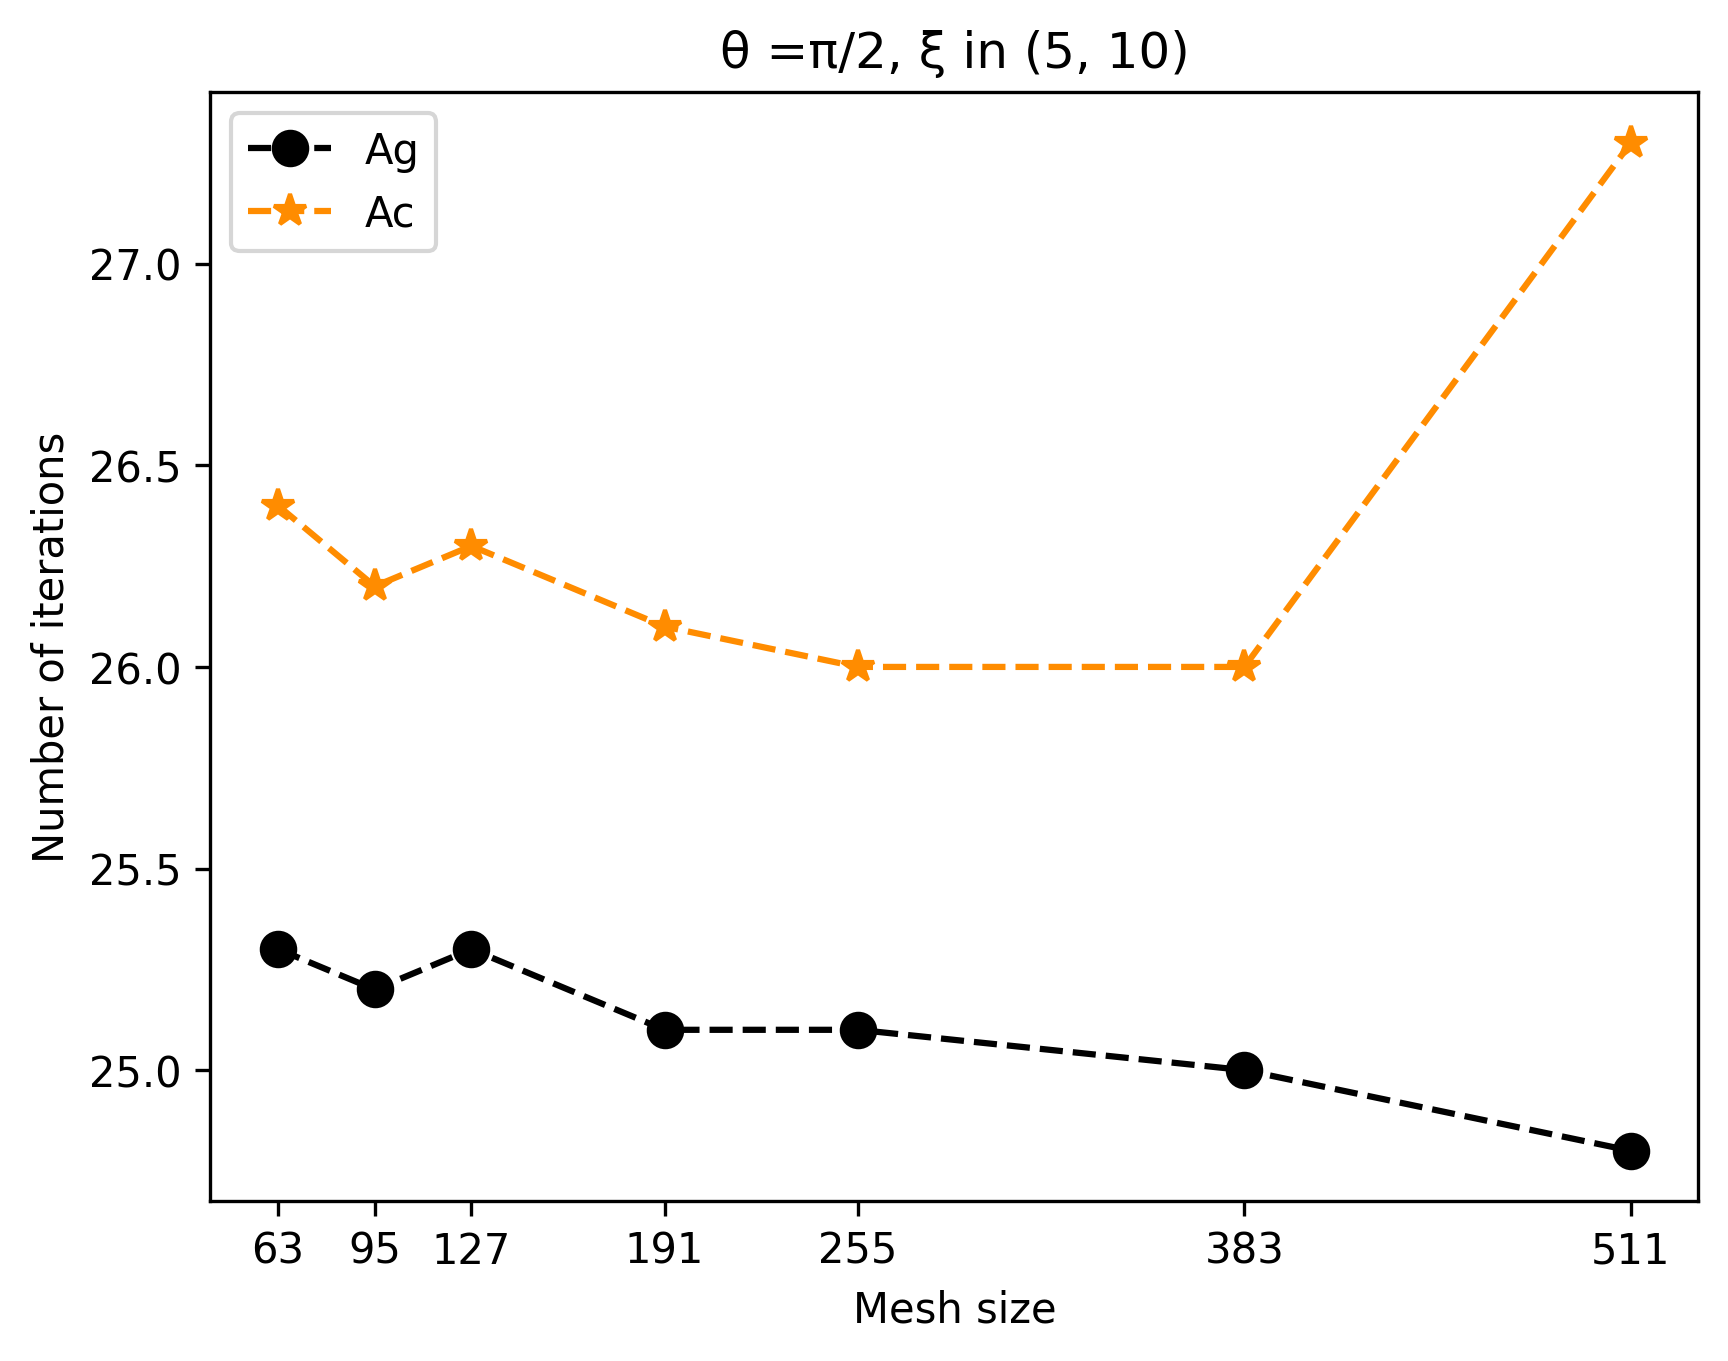

In [23]:
import matplotlib.pyplot as plt
import numpy as np

sizes = [63,95,127,191,255,383,511]
title_name = f"θ =π/{pi_num}, ξ in ({int(1/eps_high)}, {int(1/eps_low)})"

fig = plt.figure(dpi=300)
plt.plot(sizes,Ag, '--o',color='black', markersize=8, label='Ag',lw=1.5)
plt.plot(sizes,Ac, '--*',color='darkorange', markersize=8, label='Ac',lw=1.5)
plt.legend()
plt.xticks(sizes)
plt.xlabel("Mesh size")
plt.ylabel("Number of iterations")
plt.title(title_name)
file_name = MODEL_DIR + f"xi-({1/eps_high}, {1/eps_low}).png"
plt.savefig(file_name)
plt.show()

In [ ]:
from pyamg.gallery import stencil_grid
n = 511
n2 = n//2
n3 = (n//2)//2
model_prob2, model_value2
model_prob3, model_value3
model_prob2, model_value2, model_prob3, model_value3 = model_prob2.to(device), 
                                                       model_value2.to(device), 
                                                       model_prob3.to(device), 
                                                       model_value3.to(device)
PDE = RL()
eps
theta
_, _, s2, s3, _, _ = PDE.gen_data_point(31,[10,10],eps,theta)
print(s2.shape)
print(s2.shape)
Ag2 = stencil_grid(s2,(n2,n2))
Ag3 = stencil_grid(s3,(n3,n3))
print(Ag2.shape)
print(Ag3.shape)



stencil = torch.cat([stencil[0:4],stencil[5:9]]).t().to(device).double()

In [ ]:
single_model = False
softmax_on = False

stencil2 = Variable(s2.clone().squeeze(0).squeeze(0)).reshape(9,1)
stencil2 = torch.cat([stencil2[0:4],stencil2[5:9]]).t().to(device).double()
prob2 = model_prob2(stencil2).squeeze()
value2 = model_value2(stencil2).squeeze()
c2 = PDE.sparsify(prob2,value2,single_model,softmax_on).squeeze()
print(c2.shape) # (3,3)
c2 = c2.detach().cpu().numpy()

stencil3 = Variable(s3.clone().squeeze(0).squeeze(0)).reshape(9,1)
stencil3 = torch.cat([stencil3[0:4],stencil3[5:9]]).t().to(device).double()
prob3 = model_prob3(stencil3).squeeze()
value3 = model_value3(stencil3).squeeze()
c3 = PDE.sparsify(prob3,value3,single_model,softmax_on).squeeze()
c3 = c3.detach().cpu().numpy()

In [ ]:
Ac2 = stencil_grid(c2,(n2,n2))#torch.from_numpy(*.toarray())
Ac3 = stencil_grid(c3,(n3,n3))